<a href="https://colab.research.google.com/github/Sadegh08/3D-Printer-dataset-to-detect-anomalies/blob/main/Mohammad_Sadegh_Javadi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Training 3D printer dataset

> This notebook is mainly adapted from [OpenAI work](https://github.com/gabrielhuang/reptile-pytorch)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Crop version
!pip install timm
!pip install gdown==4.4.0
!gdown 1Fq0DkvzoB3wI6a8IgPeYplD01c-WmXvn -O tmp.zip && unzip -q tmp.zip && rm tmp.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14776 sha256=284aeb1e1f15dad7e14b706268338fc086e43125bec98a51005ac77a026ec7de
  Stored in directory: /root/.cache/pip/wheels/7d/37/b6/b2a79c75e898c0b8e46ff255102602d7159a10d9af0d80641a
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Access denied with the following error:

 	Cannot retrieve the public link of

In [ ]:
import os
import glob
import random

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.datasets import ImageFolder

import timm
from tqdm import tqdm

from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm 

from sklearn.metrics import f1_score, accuracy_score

## Creat training and testing validation

In [ ]:
random.seed(0)

# Set up training dataset
train_no_defect = [
    file for file in glob.glob("/content/drive/MyDrive/Python/Mohammad_Sadegh_Javadi(Session_1)/Documentation/no_defected/*.jpg") if "scratch_2" not in file]
train_yes_defect = [
    file for file in glob.glob("/content/drive/MyDrive/Python/Mohammad_Sadegh_Javadi(Session_1)/Documentation/defected/*.jpg") if "no_bottom" not in file
]
train_yes_defect = random.choices(train_yes_defect, k=len(train_no_defect))

# Set up validation dataset
val_no_defect = [
    file for file in glob.glob("/content/drive/MyDrive/Python/Mohammad_Sadegh_Javadi(Session_1)/Documentation/no_defected/*.jpg") if "scratch_2" in file]
val_yes_defect = [
    file for file in glob.glob("/content/drive/MyDrive/Python/Mohammad_Sadegh_Javadi(Session_1)/Documentation/defected/*.jpg") if "no_bottom" in file]

## Explore the data

In [ ]:
# Count the number of the the class
# Training
count_train_no_defect = len(train_no_defect)
count_train_defect = len(train_yes_defect)

# Validation
count_val_no_defect = len(val_no_defect)
count_val_defect = len(val_yes_defect)

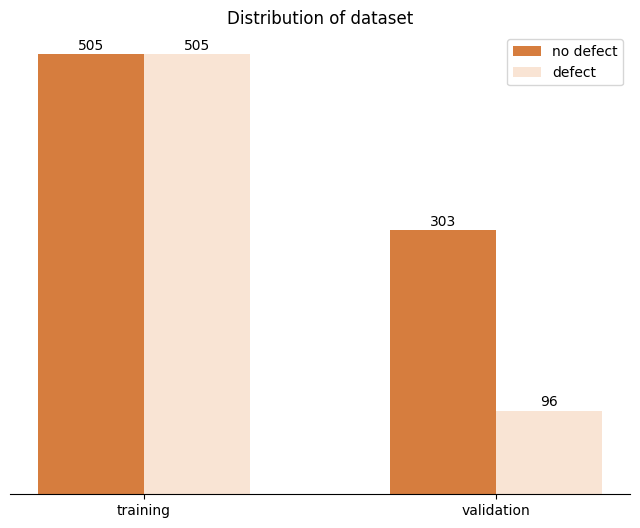

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Set up title and and x label
x_title = ["training", "validation"]
no_defect_score = [count_train_no_defect, count_val_no_defect]
defect_score = [count_train_defect, count_val_defect]
x = np.arange(len(x_title))
width = 0.3

# Plot the data
bar1 = ax.bar(x, no_defect_score, width, color="#D67D3E", label="no defect")
bar2 = ax.bar(x + width, defect_score, width, color="#F9E4D4", label="defect")

# Add heights above the bar plot
for rect, height in zip(bar1 + bar2, no_defect_score + defect_score):
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0, height + 2,
        f"{height:.0f}", ha="center", va="bottom")

# Beautify the plot (optional)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(x_title)
ax.set_yticks([])
ax.set_title("Distribution of dataset")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

# Show the annotation to each bar
plt.legend()
plt.savefig("data.pdf", transparent=True)

In [ ]:
# Set up title and and x label
x_title = ["training", "validation"]
no_defect_score = [count_train_no_defect, count_val_no_defect]
defect_score = [count_train_defect, count_val_defect]
x = np.arange(len(x_title))
width = 0.3

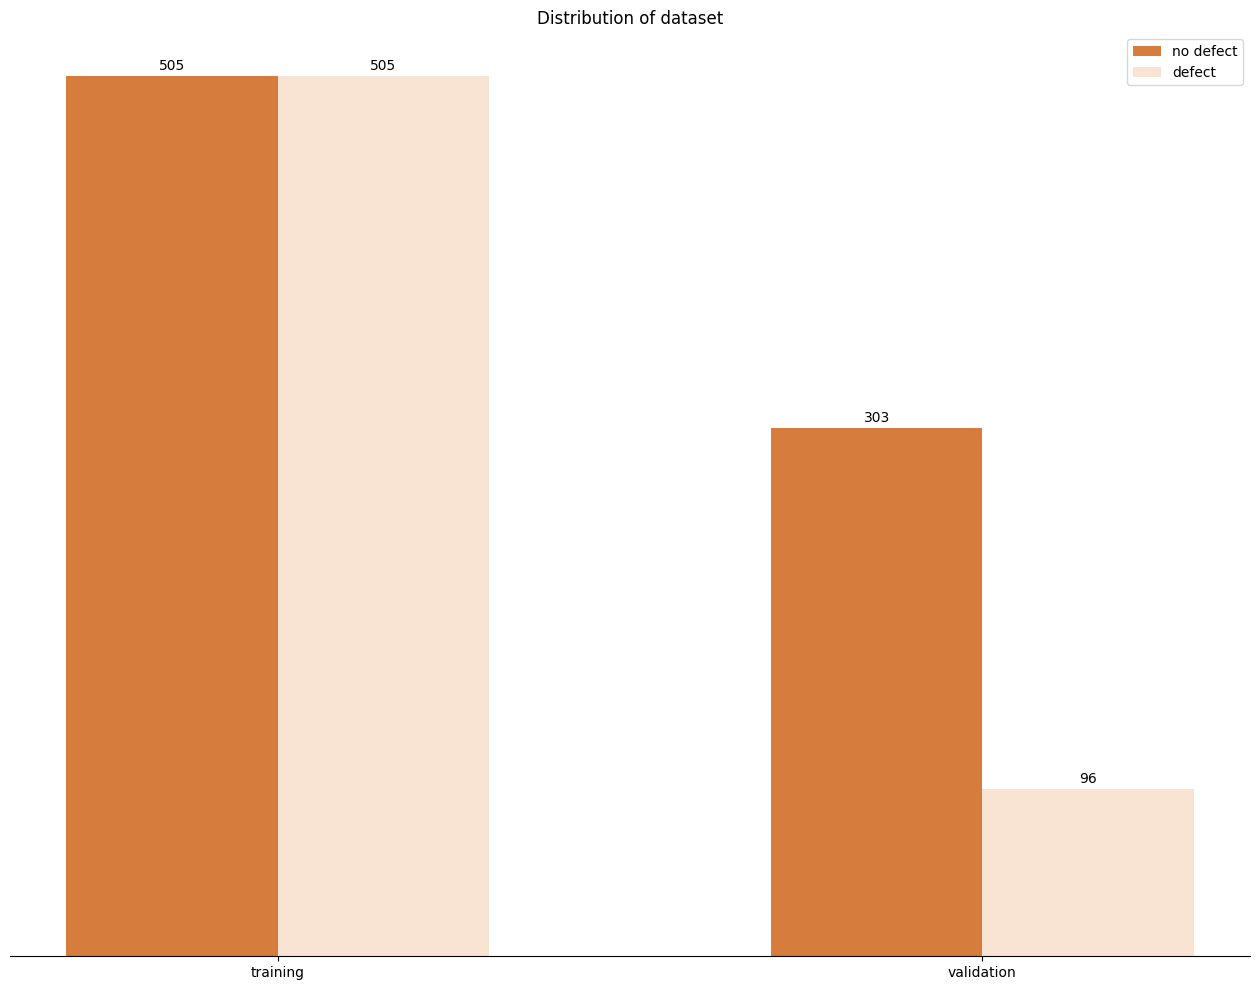

In [ ]:

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)

# Set up title and and x label
x_title = ["training", "validation"]
no_defect_score = [count_train_no_defect, count_val_no_defect]
defect_score = [count_train_defect, count_val_defect]
x = np.arange(len(x_title))
width = 0.3

# Plot the data
bar1 = ax.bar(x, no_defect_score, width, color="#D67D3E", label="no defect")
bar2 = ax.bar(x + width, defect_score, width, color="#F9E4D4", label="defect")

# Add heights above the bar plot
for rect, height in zip(bar1 + bar2, no_defect_score + defect_score):
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0, height + 2,
        f"{height:.0f}", ha="center", va="bottom")

# Beautify the plot (optional)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(x_title)
ax.set_yticks([])
ax.set_title("Distribution of dataset")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

# Show the annotation to each bar
plt.legend()
plt.savefig("data.pdf", transparent=True)

In [ ]:
# 0.75 no for acc
# Guess all samples to be 1 (yes defect)
print("Guess all yes defect",
      f1_score([0]*count_val_no_defect + [1]*count_val_defect, [1] * (count_val_no_defect + count_val_defect), average="macro"))
# Guess all samples to be 0 (no defect)
print("Guess all no defect", 
      f1_score([0]*count_val_no_defect + [1]*count_val_defect, [0]*(count_val_no_defect + count_val_defect), average="macro"))

Guess all yes defect 0.19393939393939394
Guess all no defect 0.43162393162393164


## Create Meta Dataset

In [ ]:
class FewShotDataset(Dataset):
    def __init__(self, img_list, transform):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        label, path = self.img_list[idx]
        img = Image.open(path)
        img = self.transform(img)
        return img, label

In [ ]:
class MetaPrinterFolder:
    def __init__(self, no_defect, yes_defect, 
                 train_transform=None, val_transform=None):
        self.no_defect = no_defect
        self.yes_defect = yes_defect
        self.train_transform = train_transform
        self.val_transform = val_transform
        
    def get_random_task(self, K=1):
        train_task, _ = self.get_random_task_split(train_K=K, test_K=0)
        return train_task

    def get_random_task_split(self, train_K=1, test_K=1):
        train_samples = []
        test_samples = []
        
        sample_num = train_K + test_K
        # ====== Good list =======
        for idx, path in enumerate(np.random.choice(self.no_defect, sample_num, replace=False)): 
                                                    
            if idx < train_K:
                train_samples.append((0, path))
            else:
                test_samples.append((0, path))

        # ====== Bad list =======
        for i, path in enumerate(np.random.choice(self.yes_defect, sample_num, replace=False)):
            if i < train_K:
                train_samples.append((1, path))
            else:
                test_samples.append((1, path))

        train_task = FewShotDataset(train_samples, self.train_transform)
        test_task = FewShotDataset(test_samples, self.val_transform)
                             
        return train_task, test_task

In [ ]:
filenames = glob.glob(os.path.join('/stim/','line*.png'))

# DEBUG:
print(filenames)

# need to start with an empty list
images = []
# create an image stimulus from each file, and store in the list:
for file in filenames:
    images.append(visual.ImageStim(win=win, image=file))

# DEBUG:
print(images)

[]
[]


In [ ]:
demo_transform = transforms.Compose([transforms.ToTensor(),
    transforms.Resize((400, 400)),
    transforms.CenterCrop((352, 352)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
 
meta_3d_printer = MetaPrinterFolder(
    train_no_defect, train_yes_defect, demo_transform, demo_transform)
train_task = meta_3d_printer.get_random_task()

## Create Model

In [ ]:
class ReptileModel(nn.Module):
    def __init__(self):
        super().__init__()

    def point_grad_to(self, target):
        self.zero_grad()
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                if self.is_cuda():
                    p.grad = torch.zeros(p.size()).cuda()
                else:
                    p.grad = torch.zeros(p.size())
            p.grad.data.add_(p.data - target_p.data)

    def is_cuda(self):
        return next(self.parameters()).is_cuda

In [ ]:
class TrainModel(ReptileModel):
    def __init__(self, model_name="resnet34", pretrained=True, num_classes=2):
        super().__init__()
        
        # Model settings
        self.model_name = model_name
        self.pretrained=pretrained
        self.num_classes = num_classes

        # Check out the doc: https://rwightman.github.io/pytorch-image-models/
        #  for different models
        self.model = timm.create_model(model_name, pretrained=pretrained)
        
        # Change the output linear layers to fit the output classes
        self.model.fc = nn.Linear(
            self.model.fc.weight.shape[1],
            num_classes
        )

    def forward(self, x):
        return self.model(x)

    def clone(self):
        clone = TrainModel(self.model_name, self.pretrained, self.num_classes)
        clone.load_state_dict(self.state_dict())
        if self.is_cuda():
            clone.cuda()
        return clone

## Set up training pipe

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader, args):
    model.eval()

    total_predict = []
    total_ground_truth = []
    for iteration in range(args.iterations):
        data, label = val_loader.__next__()
        data = data.to(args.device)
        label = label.to(args.device)

        output = model(data)
        prediction = output.argmax(dim=-1)

        total_predict.extend(prediction.cpu().tolist())
        total_ground_truth.extend(label.cpu().tolist())

    return accuracy_score(total_ground_truth, total_predict), \
           f1_score(total_ground_truth, total_predict, average="macro")

In [ ]:
def train_iter(model, train_loader, criterion, optimizer, args):
    model.train()
    for iteration in range(args.iterations):
        data, label = train_loader.__next__()
        data = data.to(args.device)
        label = label.to(args.device)

        # Send data into the model and compute the loss
        output = model(data)
        loss = criterion(output, label)

        # Update the model with back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

In [ ]:
def get_optimizer(net, args, state=None):
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
    if state is not None:
        optimizer.load_state_dict(state)
    return optimizer

In [ ]:
def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
def make_infinite(dataloader):
    while True:
        for x in dataloader:
            yield x

In [ ]:
def meta_train_reptile(args, meta_model, meta_train, meta_test, meta_optimizer, criterion):
    for meta_iteration in tqdm(range(args.start_meta_iteration, args.meta_iterations)):
        # Update learning rate
        meta_lr = args.meta_lr * (1. - meta_iteration / float(args.meta_iterations))
        set_learning_rate(meta_optimizer, meta_lr)

        # Clone model
        net = meta_model.clone()
        optimizer = get_optimizer(net, args)

        # Sample base task from Meta-Train
        train_dataset = meta_train.get_random_task(args.train_shots)
        infinite_train_loader = make_infinite(
            DataLoader(
                train_dataset, args.batch_size, shuffle=True,
                num_workers=2, pin_memory=True))

        # Update fast net
        train_iter(net, infinite_train_loader, criterion, optimizer, args)

        # Update slow net
        meta_model.point_grad_to(net)
        meta_optimizer.step()

        # Meta-Evaluation
        if meta_iteration % args.validate_every == 0:
            for (meta_dataset, mode) in [(meta_test, "val")]:
                train, test = meta_dataset.get_random_task_split(
                    train_K=args.shots, test_K=5)
                infinite_train_loader = make_infinite(
                    DataLoader(
                        train, args.batch_size, shuffle=True,
                        num_workers=2, pin_memory=True))
                infinite_test_loader = make_infinite(
                    DataLoader(
                        test, args.batch_size, shuffle=True,
                        num_workers=2, pin_memory=True))

                # Base-train
                net = meta_model.clone()
                optimizer = get_optimizer(net, args)
                train_iter(
                    net, infinite_train_loader, criterion, optimizer, args)

                # Base-test: compute meta-loss, which is base-validation error
                meta_acc, meta_f1 = evaluate(net, infinite_test_loader, args)
                print(f"\n{mode}: f1-accuracy: {meta_f1:.3f}, acc: {meta_acc:.3f}")

        if meta_iteration % args.check_every == 0:
            torch.save(meta_model.state_dict(), "cur.pt")

## Combine all

In [ ]:
class args:
    # Training
    epochs = 30
    batch_size = 32
    train_shots = 10
    shots = 5
    meta_iterations = 1000
    start_meta_iteration = 0
    iterations = 5
    test_iterations = 50
    meta_lr = 0.1
    validate_every = 50
    check_every = 100
    lr = 3e-4
    weight_decay=1e-5
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Transform
    size = 400
    crop_size = 352
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

In [ ]:
# Set up train loader and test loader
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((args.size, args.size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=args.mean, std=args.std)
])
val_transform = transforms.Compose([
    transforms.ToTensor(),                                    
    transforms.Resize((args.size, args.size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.Normalize(mean=args.mean, std=args.std)
])

In [ ]:
# Set up model
meta_model = TrainModel().to(args.device)
criterion = nn.CrossEntropyLoss()
meta_optimizer = torch.optim.SGD(
    meta_model.parameters(), lr=args.meta_lr)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


In [ ]:
meta_train = MetaPrinterFolder(
    train_no_defect, train_yes_defect, train_transform, val_transform)
meta_test = MetaPrinterFolder(
    val_no_defect, val_yes_defect, train_transform, val_transform)

In [ ]:
# Start training
meta_train_reptile(args, meta_model, meta_train, meta_test, meta_optimizer, criterion)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.1


val: f1-accuracy: 1.000, acc: 1.000


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.333, acc: 0.500


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.524, acc: 0.600


 10%|█         | 101/1000 [12:04<2:05:36,  8.38s/it]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 


val: f1-accuracy: 1.000, acc: 1.000


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.524, acc: 0.600


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.333, acc: 0.500


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.524, acc: 0.600


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.333, acc: 0.500


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.333, acc: 0.500


 40%|████      | 401/1000 [33:15<1:14:04,  7.42s/it]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 


val: f1-accuracy: 0.524, acc: 0.600


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.333, acc: 0.500


 50%|█████     | 501/1000 [40:15<58:01,  6.98s/it]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr


val: f1-accuracy: 0.524, acc: 0.600


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.524, acc: 0.600


 60%|██████    | 601/1000 [47:23<51:35,  7.76s/it]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr


val: f1-accuracy: 0.792, acc: 0.800


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.792, acc: 0.800


 70%|███████   | 701/1000 [54:46<36:31,  7.33s/it]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr


val: f1-accuracy: 0.524, acc: 0.600


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.333, acc: 0.500


 80%|████████  | 801/1000 [1:02:10<25:39,  7.74s/it]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 


val: f1-accuracy: 0.524, acc: 0.600


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 


val: f1-accuracy: 0.333, acc: 0.500


 90%|█████████ | 901/1000 [1:09:43<12:38,  7.66s/it]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 


val: f1-accuracy: 0.333, acc: 0.500


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

## Used pretrained network to train on the whole dataset

In [ ]:
class ListDataset(Dataset):
    def __init__(self, yes_defect, no_defect, transform=None):
        self.img_list = yes_defect + no_defect
        self.label = [1] * len(yes_defect) + [0] * len(no_defect)
        self.transform = transform

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx])
        label = self.label[idx]
        img = self.transform(img)
        return img, label

In [ ]:
def make_loader(yes_defect, no_defect, transform, batch_size,
                shuffle=True, num_workers=2, pin_memory=True,
                train=True):
    dataset = ListDataset(
        yes_defect=yes_defect, no_defect=no_defect, transform=transform)
    loader = DataLoader(
        dataset, batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        pin_memory=pin_memory)
    
    return loader

In [ ]:
@torch.no_grad()
def post_train_evaluate(model, val_loader, args):
    model.eval()

    total_predict = []
    total_ground_truth = []
    for data, label in val_loader:
        data = data.to(args.device)
        label = label.to(args.device)

        output = model(data)
        prediction = output.argmax(dim=-1)

        total_predict.extend(prediction.cpu().tolist())
        total_ground_truth.extend(label.cpu().tolist())

    return accuracy_score(total_ground_truth, total_predict), \
           f1_score(total_ground_truth, total_predict, average="macro")

In [ ]:
def post_train(model, train_loader, val_loader, criterion, optimizer, args):
    best_f1 = 0
    for epoch in range(args.epochs):
        train_progress_bar = tqdm(
            train_loader, desc=f"Epochs: {epoch + 1}/{args.epochs}")
        
        model.train()
        for data, label in train_progress_bar:
            data = data.to(args.device)
            label = label.to(args.device)

            # Send data into the model and compute the loss
            output = model(data)
            loss = criterion(output, label)

            # Update the model with back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute the accuracy ans save the best model
        eval_acc, eval_f1 = post_train_evaluate(model, val_loader, args)
        print(f"Validation accuracy: {eval_acc:.8f} f1-score: {eval_f1:.8f}")
        if eval_f1 > best_f1:
            best_f1 = eval_f1
            torch.save(model.state_dict(), "best.pt")

In [ ]:
train_loader = make_loader(
    yes_defect=train_yes_defect, no_defect=train_no_defect,
    batch_size=args.batch_size,
    transform=train_transform)
val_loader = make_loader(
    yes_defect=val_yes_defect, no_defect=val_no_defect,
    batch_size=args.batch_size,
    transform=val_transform, train=False)

In [ ]:
meta_model.load_state_dict(torch.load("cur.pt"))
train_model = meta_model.clone()
criterion = nn.CrossEntropyLoss()
train_optimizer = torch.optim.Adam(train_model.parameters(), lr=args.lr)

In [ ]:
# Start training
post_train(train_model, train_loader, val_loader, criterion, train_optimizer, args)
torch.save(train_model.state_dict(), "last.pt")

Epochs: 1/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 0.99749373 f1-score: 0.99658288


Epochs: 2/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 3/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 4/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 5/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 6/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 7/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 8/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 9/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 10/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 11/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 12/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 13/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 14/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 15/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 16/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 17/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 18/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 19/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 20/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 21/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 22/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 23/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 24/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 25/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 26/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 27/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 28/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 29/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


Epochs: 30/30:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to

Validation accuracy: 1.00000000 f1-score: 1.00000000


## Model Explanation

In [ ]:
class GradCAM:
    def __init__(self, model, layer_name, img_size):
        self.model = model
        self.layer_name = layer_name
        self.img_size = img_size

        # Save the forward and backward features
        self.module_list = []
        self.features_list = dict()
        self.gradient_list = dict()

        # Handlers list
        self.handlers = []
        self._register_hook()

        self.img_transform =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((400, 400)),
            transforms.CenterCrop((img_size, img_size)),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def activation_name(self, name, hook_type):
        def _get_hook(module, input, output):
            if hook_type == "forward":
                self.module = name
                self.features_list[name] = output
            elif hook_type == "backward":
                self.gradient_list[name] = output[0]
            else:
                raise ValueError(f"Nor supported hook type: {hook_type}")
        return _get_hook

    def _clear_list(self):
        self.module = None
        self.features_list = dict()
        self.gradient_list = dict()

    def _register_hook(self):
        self.handlers = []
        for (name, module) in self.model.named_modules():
            if name == self.layer_name:
                self.handlers.append(
                    module.register_forward_hook(
                        self.activation_name(name, "forward")
                    )
                )
                self.handlers.append(
                    module.register_full_backward_hook(
                        self.activation_name(name, "backward")
                    )
                )
    
    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()

    def __call__(self, img, device):
        # Clear the list
        self._clear_list()

        ori_size = img.shape[:2][::-1]
        in_features = self.img_transform(img).to(device)
        
        res = self.model(in_features.unsqueeze(0)).view(-1)
        
        self.model.zero_grad()
        predict_cls = res.argmax(dim=-1).item()
        target = res[predict_cls]
        target.backward()

        gradient = self.gradient_list[self.module].data[0]
        weight = torch.mean(gradient, dim=(1, 2), keepdim=True)

        feature = self.features_list[self.module].data[0]
        temp_cam = (feature * weight).sum(dim=0).relu()

        # Normalize the value
        temp_cam -= torch.min(temp_cam)
        temp_cam /= torch.max(temp_cam)

        temp_cam = cv2.resize(
            temp_cam.detach().cpu().numpy(), ori_size)
        heatmap = (cm.jet(temp_cam)[..., :3] * 255).astype("uint8")
        temp_cam = (img * 0.5 + heatmap * 0.5).astype("uint8")

        return temp_cam, predict_cls

In [ ]:
def save_grad_cam(model, target_layer, img_list, weight_file, save_path, args):
    # if save_path == img_root:
    #     raise ValueError("Save path should not be the same with image root, " 
    #                      "otherwise the original data will be overwritten")
    os.makedirs(save_path, exist_ok=True)

    # Define the model and grad cam instance
    new_model = model.clone()
    new_model.load_state_dict(torch.load(weight_file))
    grad_cam = GradCAM(new_model, target_layer, args.crop_size)

    for img_path in tqdm(img_list):
        img = cv2.imread(img_path)

        # Get grad cam image and save it
        res, pred = grad_cam(img, args.device)
        cv2.imwrite(f"{save_path}/{pred}_{os.path.basename(img_path)}", res)

    grad_cam.remove_handlers()

In [ ]:
save_grad_cam(
    model=train_model, target_layer="model.layer4.2.conv2",
    img_list=val_yes_defect + val_no_defect, 
    weight_file="best.pt", save_path="cam_image",
    args=args
)

100%|██████████| 399/399 [00:26<00:00, 15.10it/s]


## ONNX

| model |  time |
|: --- :|: --- :|
| torch | 0.253 |
| onnx  | 0.037 |

In [ ]:
!pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import onnx
import onnxruntime as ort

In [ ]:
# Transform the pytorch model to onnx
dummy_input = torch.randn(1, 3, 352, 352, device="cuda")

input_names = ["input"]
output_names = ["output"]

train_model.load_state_dict(torch.load("best.pt"))
train_model.eval()
torch.onnx.export(train_model, dummy_input, "resnet.onnx",
                  input_names=input_names, output_names=output_names,
                  opset_version=12)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
# Load the ONNX model
model = onnx.load("resnet.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)

In [ ]:
# Check accuracy of ONNX model

# Load model
ort_session = ort.InferenceSession("resnet.onnx")

total_correct = []
total_predict = []

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((args.size, args.size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.Normalize(mean=args.mean, std=args.std),
    transforms.Lambda(lambda x: x.unsqueeze(0).numpy())
])

ground_truth = [1] * len(val_yes_defect) + [0] * len(val_no_defect)
for label, img_path in zip(ground_truth, val_yes_defect + val_no_defect):
    # Read in image
    img = Image.open(img_path)
    
    outputs = ort_session.run(None, {"input": img_transform(img)})
    
    total_correct.append(label)
    total_predict.append(int(outputs[0][0][1] > outputs[0][0][0]))

In [ ]:
print(f"ONNX, accuracy: {accuracy_score(total_correct, total_predict)} "
      f"f1_score: {f1_score(total_correct, total_predict)}")

ONNX, accuracy: 1.0 f1_score: 1.0
